# Predicting House Prices
This project aims to make a successful submission to [This competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## Script Initialization

In [1]:
import pandas as pd
import plotly.express as px
from IPython.display import clear_output

In [2]:
from eda import load_validated_data
from etl import transform_data, derive_fields
from modeling import evaluate_model_performance, tune_selected_models, make_ensemble_prediction

In [3]:
# Load in the two datasets, validating everything against the provided metadata
train, metadata = load_validated_data('data/train.csv')
val, _ = load_validated_data('data/test.csv')

In [4]:
# Visually inspect the loaded data
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,NaN,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,NaN,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,NaN,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,NaN,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,NaN,NA,NA,NA,0,12,2008,WD,Normal,250000


## How much are the properties worth?

In [5]:
# Generate a plot to see what the distribution of sale prices looks like
fig = px.histogram(train.reset_index(),
                   x='SalePrice',
                   y='Id',
                   marginal='box',
                   title='Distribution of Sales Prices',
                   labels={'SalePrice': 'Sale Price ($)', 'Id': 'Properties'},
                   width=1280,
                   height=720)
fig.write_image('figures/SalePriceDistribution.png', scale=4)
fig.show()

## How can we get the data into a usable format?

In [6]:
# Work out what % of each column is populated
tot_records = len(train.index)
counts = train.count(axis='index')
counts /= tot_records
counts = counts.sort_values(ascending=True)
counts = pd.DataFrame(counts, columns=['populated']).reset_index()
counts = counts.rename({'index': 'field'})
counts.loc[:, 'nulls'] = 1 - counts['populated']
counts = counts.loc[counts['populated'] < 1, :]

# Plot the output for all columns which have blank values
fig = px.bar(counts,
             x='index',
             y='populated',
             title='Availability of Data',
             labels={'populated': 'Populated (%)', 'index': 'Field'},
             height=720,
             width=1280)
fig.write_image('figures/DataAvailability.png', scale=4)
fig.show()

<b>Recommendations for missing values</b>
* PoolArea - This will be dropped in favour of PoolQC which is fully populated
* 3SsnPorch, ScreenPorch, EnclosedPorch, OpenPorchSF - These will be merged into a single Porch column
* LowQualFinSF - Would expect this to be mostly empty, fill blanks with 0
* BsmtFinSF2 - Will be dropped in favour of BsmtFinType2 which is fully populated
* SaleType - Dropped as I can't see any good way to fill in the gaps
* MasVnrArea - Drop in favour of MasVnrType
* 2ndFlrSF - Fill with mean if the building isn't a 1-storey construction
* WoodDeckSF - Fill gaps with 0, no decking
* BsmtFinSF1 - Fill blanks with 0 if BsmtFinType1 is NA, otherwise use TotalBsmtSF - BsmtUnfSF
* LotFrontage - Fill blanks with the mean
    * Outliers in this field, leaving as-is for now but model could be improved by using median
* BsmtUnfSF - Fill blanks with 0
* GarageArea - Fill blanks with 0
* GarageYrBlt - Fill blanks mean
    * Hopefully less impact on overall model than filling with 0s as this is a numerical field
    * Could add a GaragePresent field to mitigate this further in future revisions
* TotalBsmtSF - fill blanks with 0
* Electrical - Fill blanks with mode

In [8]:
# Visually check the distribution of values for each field
for col in train.columns:
    clear_output()
    plot_df = train.dropna(subset=[col])
    fig = px.histogram(plot_df.reset_index(), x=col, y='Id', title=col, width=1280, height=720)
    fig.show()
    check = input('Enter to continue, q to quit, p to save plot to image')
    if check == 'q':
        clear_output()
        break
    elif check == 'p':
        fig.write_image(f'figures/{col}.png', scale=4)
clear_output()

<b> Notes on field contents </b>
* LotFrontage has an outlier at 310
* LotArea highly skewed
* Street almost entirely Pave
* Alley might as well be switched over to binary format
* Utilities could probably be dropped due to low variance
* Condition2 could probably be dropped
* Heating could probably be dropped
* Full/Half bath columns can be merged, little data in half bath columns
* MiscFeature is almost entirely sheds, just keep the numerical equivalent MiscVal

## Which type of model performs the best?
### Prepare the data

In [9]:
# Fill in/replace values to cleanse the dataset
train = transform_data(train, metadata)
val = transform_data(val, metadata)

In [10]:
# Derive extra fields to assist with model fitting
train, val = derive_fields(train, val, metadata)

In [11]:
# Split into X, y datasets
# Note that train/test split is not called explicitly as it's built into the
#     cross validation process
features = val.columns.tolist()

X_full = train[features]
y_full = train['SalePrice']
X_val = val[features]

In [12]:
# Test the various candidate algorithms
algo_results = evaluate_model_performance(X_full, y_full)

BayesianRidge:  25%|██▌       | 4/16 [00:09<00:27,  2.25s/it]

KeyboardInterrupt: 

In [ ]:
# Evaluate model performance on train/test datasets
pretty_results = algo_results.copy()
pretty_results['train_score'] = pretty_results['train_score'].map('{:,.0f}'.format)
pretty_results['test_score'] = pretty_results['test_score'].map('{:,.0f}'.format)
pretty_results

In [ ]:
# Use RandomSearchCV to find the best set of parameters for each model
cand_results, models = tune_selected_models(X_full, y_full, X_val)

In [ ]:
# Inspect final results for the 4 candidate models
cand_results

In [ ]:
# Finally, use an ensemble regressor to try and eke out a bit more performance
make_ensemble_prediction(X_full, y_full, X_val, models)

## Which features have the greatest importance in determining price?

In [23]:
# Extract the fitted GradientBoostingRegressor object
GBoost = models[0][1]

# Get a list of columns and the corresponding feature importances
records = list(zip(X_full.columns, GBoost.feature_importances_))

# Parse list into a dataframe, bring through field descriptions from metadata
features = pd.DataFrame.from_records(records, columns=['field', 'importance'])
features = features.sort_values(by='importance', ascending=False)
features.loc[:, 'base_field'] = features['field'].map(lambda x: x.split('_')[0])
features.loc[:, 'field_desc'] = features['base_field'].map(
    lambda x: metadata[x]['description'] if x in metadata else pd.NA)
features = features[['field', 'field_desc', 'importance']]

# Visually inspect feature importances
features.head(20)

,field,field_desc,importance
5,OverallQual,Rates the overall material and finish of the h...,0.469924
16,GrLivArea,Above grade (ground) living area square feet,0.119072
82,Neighborhood_mean,Physical locations within Ames city limits,0.093229
11,TotalBsmtSF,Total square feet of basement area,0.051652
26,GarageCars,Size of garage in car capacity,0.038719
13,1stFlrSF,First Floor square feet,0.035390
9,BsmtFinSF1,Type 1 finished square feet,0.034019
14,2ndFlrSF,Second floor square feet,0.025269
100,ExterQual_mean,Evaluates the quality of the material on the e...,0.012729
80,Neighborhood_min,Physical locations within Ames city limits,0.009716


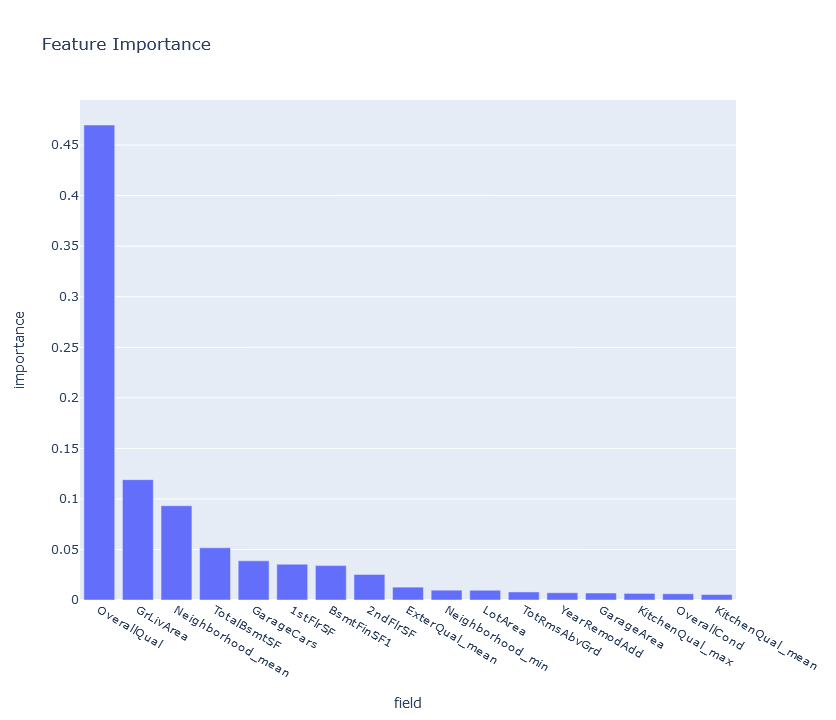

In [25]:
# Generate a plot showing feature importance above a threshold
plot_features = features.loc[features['importance'] >= 0.005, :]
fig = px.bar(plot_features,
             x='field',
             y='importance',
             hover_data=['field_desc'],
             width=1280,
             height=720,
             title='Feature Importance')
fig.write_image('figures/FeatureImportance.png', scale=4)
fig.show()

## How close did we really get?

In [26]:
# Make predictions using the GradientBoostingRegressor
y_preds = GBoost.predict(X_full)

In [27]:
# Add predictions to a dataframe along with the actual values
results = train[['SalePrice']].copy()
results.loc[:, 'Predicted'] = y_preds

# Calculate prediction variance from true values
results.loc[:, 'Variance'] = results['SalePrice'] - results['Predicted']

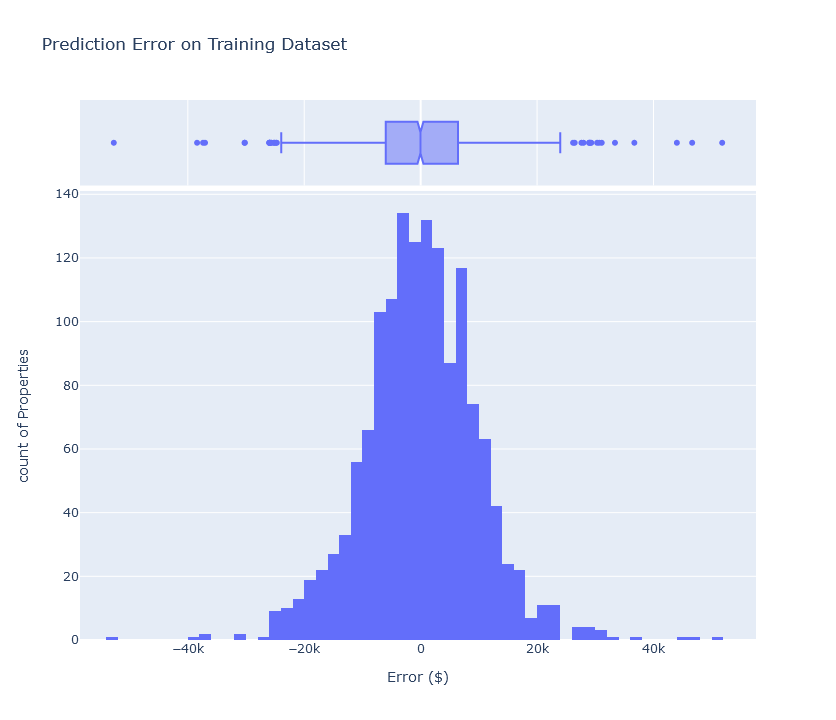

In [31]:
# Generate a plot showing the distribution of the variance
fig = px.histogram(
    results.reset_index(),
    x='Variance',
    y='Id',
    marginal='box',
    labels={'Variance': 'Error ($)', 'Id': 'Properties'},
    title='Prediction Error on Training Dataset',
    width=1280,
    height=720)
fig.write_image('figures/PredictionErrors.png', scale=4)
fig.show()